# Lab 4: Basic regression - Predict fuel efficiency



## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # we use this library to load the dataset
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2026-02-08 15:43:02.668969: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Load data

In [2]:
# Load the 'mpg' dataset using seaborn library into a Pandas DataFrame
df = sns.load_dataset('mpg')

MPG dataset can be viewed online at  
https://github.com/mwaskom/seaborn-data/blob/master/mpg.csv

## Data Exploration - Pandas Review

### Show the first 5 rows of the dataset

In [3]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


### Show the size of the dataframe

In [4]:
df.shape

(398, 9)

### Find the columns name and their types (numerical or categorical)

In [5]:
df.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower      float64
weight            int64
acceleration    float64
model_year        int64
origin           object
name             object
dtype: object

### Find the number of missing values in each column

In [6]:
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

### Handle the missing values in the dataframe

Since the number of missing values is low, we can simply drop the rows containing them. However, as a practice and review, let's substitute the missing values in the numerical columns (if any) with the mean of the respective column and the missing values in the categorical columns (if any) with the median of the respective column.

In [7]:
# Fill missing values in numerical columns with the mean
numerical_cols = df.select_dtypes(include='number').columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Fill missing values in categorical columns with the mode
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# Verify no missing values remain
df.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
name            0
dtype: int64

### Compute the average and the median weight

In [8]:
print('Average weight:', df['weight'].mean())
print('Median weight:', df['weight'].median())

Average weight: 2970.424623115578
Median weight: 2803.5


### Find the number of cars that weight more than 2000 kgs

In [9]:
print('Number of cars weighing more than 2000 kgs:', len(df[df['weight'] > 2000]))

Number of cars weighing more than 2000 kgs: 354


### Find how many cars there are for each number of cylinders

In [10]:
df['cylinders'].value_counts()

cylinders
4    204
8    103
6     84
3      4
5      3
Name: count, dtype: int64

### Find what are the car models with number of cylinders (3 or 5)

In [11]:
df[df['cylinders'].isin([3, 5])][['name', 'cylinders']]

,name,cylinders
71,mazda rx2 coupe,3
111,maxda rx3,3
243,mazda rx-4,3
274,audi 5000,5
297,mercedes benz 300d,5
327,audi 5000s (diesel),5
334,mazda rx-7 gs,3


### Show the `value_counts()` of `origin` column or show the unique values of this column.

In [12]:
df['origin'].value_counts()

origin
usa       249
japan      79
europe     70
Name: count, dtype: int64

## Data Preprocessing

### Use one hot encoding to change the categorical values of `origin` column to numerical values.

- use `pd.get_dummies()` method to do the encoding
- Join the original DataFrame with the new dummy DataFrame with `pd.concat()` and use `axis=1` to concate in horizontal direction.

In [13]:
origin_dummies = pd.get_dummies(df['origin'], dtype=float)
df = pd.concat([df, origin_dummies], axis=1)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name,europe,japan,usa
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu,0.0,0.0,1.0
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320,0.0,0.0,1.0
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite,0.0,0.0,1.0
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst,0.0,0.0,1.0
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino,0.0,0.0,1.0


### Remove the `name` and `origin` column form the dataframe to have all numerical dataframe.

In [14]:
df = df.drop(['name', 'origin'], axis=1)
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,europe,japan,usa
0,18.0,8,307.0,130.0,3504,12.0,70,0.0,0.0,1.0
1,15.0,8,350.0,165.0,3693,11.5,70,0.0,0.0,1.0
2,18.0,8,318.0,150.0,3436,11.0,70,0.0,0.0,1.0
3,16.0,8,304.0,150.0,3433,12.0,70,0.0,0.0,1.0
4,17.0,8,302.0,140.0,3449,10.5,70,0.0,0.0,1.0


### Does the input needs reshaping?

In [15]:
# No reshaping needed - the data is already in 2D tabular format (samples, features)
print('Shape:', df.shape)

Shape: (398, 10)


### Form features `X` and labels `y` based on the processed datafram

In [16]:
X = df.drop('mpg', axis=1)
y = df['mpg']

### Split the data into training and test sets and form `train_features`, `train_labels`, `test_features`, `test_labels`

In [17]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size=0.2, random_state=42)

### For simplicity in the following steps, convert the dataset from a pandas DataFrame to a numpy array.

In [18]:
train_features = np.array(train_features)
train_labels = np.array(train_labels)
test_features = np.array(test_features)
test_labels = np.array(test_labels)

### Do some sanity check on the shape of the data before building a model

In [19]:
print('Train features shape:', train_features.shape)
print('Train labels shape:', train_labels.shape)
print('Test features shape:', test_features.shape)
print('Test labels shape:', test_labels.shape)

Train features shape: (318, 9)
Train labels shape: (318,)
Test features shape: (80, 9)
Test labels shape: (80,)


## Normalization layer

To ensure stable training of neural networks, we typically normalize the data. This process also enhances the convergence of the gradient descent algorithm.

There is not single way to normalize the data. You can also use `scikit-learn `or `pandas` to do it. However, in this lab, we will use the normalization layer provided by tensorflow which matches the other parts of the model.

The `tf.keras.layers.Normalization` is a clean and simple way to add feature normalization into your model.

The first step is to create the layer:

In [20]:
normalizer = tf.keras.layers.Normalization(axis=-1)

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`.

It calculates the mean and variance of each feature, and store them in the layer

In [21]:
normalizer.adapt(train_features)

When the layer is called, it returns the input data, with each feature independently normalized.

In [22]:
first = train_features[0]
print('First example:', first)
print()
print('Normalized:', normalizer(first).numpy())

First example: [8.000e+00 3.040e+02 1.500e+02 3.433e+03 1.200e+01 7.000e+01 0.000e+00
 0.000e+00 1.000e+00]

Normalized: [[ 1.5271882   1.0901965   1.2618345   0.55282634 -1.3193338  -1.6966677
  -0.46232074 -0.5117663   0.7889543 ]]


## **Approach #1:** Regression using `Linear Regression`

**You are welcome to use scikit-learn to perform linear regression on this dataset.**

However, here we aim to implement it using TensorFlow.

- As we saw in Lab Week 2, `logistic regression` is essentially a single neuron with a `sigmoid` activation function.

- Similarly, `linear regression` can be viewed as a single neuron with a `linear` activation function.

### **Step 1:** Linear regression model architecture

In [23]:
linear_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(9,)),
    normalizer,
    layers.Dense(1, activation='linear')
])

**Note:** You can define your model all at once like the cell above or you can buid the model incrementaly  (suitable for your assignment)

In [24]:
# Defining the model incrementaly (suitable for your assignment)
linear_model = tf.keras.Sequential()
linear_model.add(tf.keras.layers.Input(shape=(9,)))
linear_model.add(normalizer)
linear_model.add(layers.Dense(1, activation='linear'))

### **Step 2:** Configure the model with Keras `Model.compile()`

The most important arguments to compile are the `loss` and the `optimizer`, since these define what will be optimized (`"mean_absolute_error"`) and how (using the `tf.keras.optimizers.Adam(learning_rate=0.1)`).

**arguments:**
- optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
- loss='mean_absolute_error'

In [25]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

### **Step 3:** Train the model using the `Model.fit()` for `100` epochs, and store the output in a variable named history.

In [26]:
history = linear_model.fit(train_features, train_labels, epochs=100)

Epoch 1/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - loss: 22.2593

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23.1944  


Epoch 2/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 21.1866

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22.1834 


Epoch 3/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 20.7469

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.1858 


Epoch 4/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 22.1050

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.1968 


Epoch 5/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 18.9685

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.1729 


Epoch 6/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 15.8331

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.1762 


Epoch 7/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 17.3224

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.1669 


Epoch 8/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 17.9213

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.1905 


Epoch 9/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 16.1816

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.1932 


Epoch 10/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 13.5435

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.1982 


Epoch 11/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 11.8626

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.2247 


Epoch 12/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 11.0184

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.2108 


Epoch 13/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 11.1495

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2060 


Epoch 14/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 10.7491

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.2394 


Epoch 15/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 11.0325

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2299  


Epoch 16/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.6957

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.2385 


Epoch 17/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 7.6478

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2636 


Epoch 18/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 6.1255

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.3599 


Epoch 19/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.1832

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.4336 


Epoch 20/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 6.6018

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6526 


Epoch 21/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 4.3050

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9892 


Epoch 22/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.0648

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4708 


Epoch 23/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.7453

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0923 


Epoch 24/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.7266

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8595 


Epoch 25/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.7704

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7311 


Epoch 26/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5365

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6626 


Epoch 27/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.3690

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6030 


Epoch 28/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.1100

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5854 


Epoch 29/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0024

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5683 


Epoch 30/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.1795

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5827 


Epoch 31/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8414

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5576 


Epoch 32/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9374

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5571 


Epoch 33/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.3904

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5863 


Epoch 34/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6334

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5813 


Epoch 35/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1258

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5542 


Epoch 36/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6028

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5614 


Epoch 37/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.5328

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5529 


Epoch 38/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.1450

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5473 


Epoch 39/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.5632

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5729 


Epoch 40/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9627

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5536 


Epoch 41/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6071

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5570 


Epoch 42/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.7367

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5789 


Epoch 43/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.4373

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5632 


Epoch 44/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0289

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5522 


Epoch 45/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7790

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5584 


Epoch 46/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.9432

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5540 


Epoch 47/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.9038

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5760 


Epoch 48/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.5547

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5636 


Epoch 49/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2697

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5611 


Epoch 50/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2271

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5466 


Epoch 51/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6134

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5437 


Epoch 52/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2486

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5455 


Epoch 53/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8060

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5506 


Epoch 54/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2898

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5607 


Epoch 55/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.1138

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5570 


Epoch 56/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1229

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5649 


Epoch 57/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0681

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5668 


Epoch 58/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7956

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5880 


Epoch 59/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0953

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5605 


Epoch 60/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0554

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5882 


Epoch 61/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.7295

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6529 


Epoch 62/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.3729

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6043 


Epoch 63/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.9468

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5688 


Epoch 64/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2672

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5630 


Epoch 65/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6679

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5659 


Epoch 66/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0528

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5701 


Epoch 67/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.3241

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5597 


Epoch 68/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.7635

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5974 


Epoch 69/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2542

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5633 


Epoch 70/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1662

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5468 


Epoch 71/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.8872

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5453 


Epoch 72/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2638

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5701 


Epoch 73/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0793

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5472 


Epoch 74/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.8163

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5519 


Epoch 75/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.6224

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5472 


Epoch 76/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.4838

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5462 


Epoch 77/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2136

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6490 


Epoch 78/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.5451

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6585 


Epoch 79/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6568

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5518 


Epoch 80/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.3494

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5668 


Epoch 81/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.3417

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5533 


Epoch 82/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.8989

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5451 


Epoch 83/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4873

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5566 


Epoch 84/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.2724

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5669 


Epoch 85/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4942

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5506 


Epoch 86/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.4843

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5430 


Epoch 87/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7162

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5569 


Epoch 88/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.5595

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5887 


Epoch 89/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5365

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6284 


Epoch 90/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0002

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5895 


Epoch 91/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 2.4610

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5634  


Epoch 92/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.2586

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5506 


Epoch 93/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0543

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5567 


Epoch 94/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0485

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5535 


Epoch 95/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0483

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5580 


Epoch 96/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6626

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5923 


Epoch 97/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.9800

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.5873 


Epoch 98/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.7656

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5804 


Epoch 99/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2600

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5686 


Epoch 100/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.3769

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5619 


In [27]:
history.history

{'loss': [23.19437599182129,
  22.183435440063477,
  21.185802459716797,
  20.196815490722656,
  19.172903060913086,
  18.176193237304688,
  17.166881561279297,
  16.190475463867188,
  15.193219184875488,
  14.198179244995117,
  13.224684715270996,
  12.21082592010498,
  11.20603084564209,
  10.239419937133789,
  9.229859352111816,
  8.238454818725586,
  7.263628005981445,
  6.359879016876221,
  5.433595657348633,
  4.652599811553955,
  3.989229440689087,
  3.470766067504883,
  3.0923101902008057,
  2.8595261573791504,
  2.731085777282715,
  2.6626265048980713,
  2.602954149246216,
  2.58540415763855,
  2.5682692527770996,
  2.582728862762451,
  2.557612657546997,
  2.5570974349975586,
  2.586333751678467,
  2.581298351287842,
  2.554198741912842,
  2.5613949298858643,
  2.552932024002075,
  2.5473034381866455,
  2.572924852371216,
  2.5536186695098877,
  2.5569963455200195,
  2.5789003372192383,
  2.5631954669952393,
  2.552232027053833,
  2.5584285259246826,
  2.5540482997894287,
  2

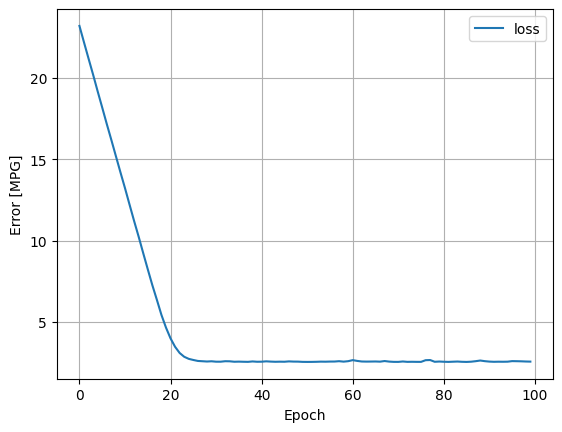

In [28]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

### Get the model summary

In [29]:
linear_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51 (212.00 B)

 Trainable params: 10 (40.00 B)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 22 (92.00 B)

### **Step 4:** Evaluate the linear model on the test set using Keras `Model.evaluate()` and see the `mean_absolute_error` and save the result for future comparison.

In [30]:
linear_test_results = linear_model.evaluate(test_features, test_labels, verbose=0)
print('Linear Regression - Mean Absolute Error on test set:', linear_test_results)

Linear Regression - Mean Absolute Error on test set: 2.239344596862793


## **Approach #2:** Regression using a `Deep Neural Network (DNN)`

### Solve the same problem and using deep neural network with the sample architecture;
- 1st hidden layer no. of units =  64
- 2nd hidden layer no. of units = 64
- Choose appropriate `activation` functions for hidden and output layers

In [31]:
dnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(9,)),
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])

dnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error'
)

dnn_history = dnn_model.fit(train_features, train_labels, epochs=100)

dnn_test_results = dnn_model.evaluate(test_features, test_labels, verbose=0)
print('DNN - Mean Absolute Error on test set:', dnn_test_results)

Epoch 1/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 6s 746ms/step - loss: 21.5560

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.2634  


Epoch 2/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 23.1969

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22.3833 


Epoch 3/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 26.1526

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21.3132 


Epoch 4/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 19.1216

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.8985 


Epoch 5/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 14.9327

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.9177 


Epoch 6/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 16.7101

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15.7297 


Epoch 7/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 14.3231

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13.4712 


Epoch 8/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12.7802

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.6859 


Epoch 9/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 9.7708

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.2627 


Epoch 10/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.9006

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9739 


Epoch 11/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.5009

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.3036 


Epoch 12/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.3284

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5866 


Epoch 13/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.4969

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2443 


Epoch 14/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.3490

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.9535 


Epoch 15/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.0236

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8028 


Epoch 16/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.6286

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6156 


Epoch 17/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.2020

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5089 


Epoch 18/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.0614

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3889 


Epoch 19/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.0304

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3300 


Epoch 20/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8706

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2726 


Epoch 21/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6260

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2585 


Epoch 22/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.2205

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1881 


Epoch 23/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.2420

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1485 


Epoch 24/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.1528

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1166 


Epoch 25/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9192

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0897 


Epoch 26/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9532

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0703 


Epoch 27/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8963

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0502 


Epoch 28/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5548

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0611 


Epoch 29/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6437

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0445 


Epoch 30/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7027

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0193 


Epoch 31/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5133

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9981 


Epoch 32/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.4570

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9981 


Epoch 33/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5926

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9738 


Epoch 34/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6554

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9782 


Epoch 35/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4976

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9692 


Epoch 36/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3111

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9573 


Epoch 37/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.7443

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9442 


Epoch 38/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.1210

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9362 


Epoch 39/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3267

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9327 


Epoch 40/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9760

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9308 


Epoch 41/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3168

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9186 


Epoch 42/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3735

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9193 


Epoch 43/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6261

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9018 


Epoch 44/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7354

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9021 


Epoch 45/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3438

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8990 


Epoch 46/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8657

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8816 


Epoch 47/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.7720

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8743 


Epoch 48/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7337

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8811 


Epoch 49/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.0300

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8654 


Epoch 50/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8036

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8579 


Epoch 51/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5328

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8556 


Epoch 52/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.8133

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8557 


Epoch 53/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7792

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8670 


Epoch 54/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5603

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8487 


Epoch 55/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6396

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8351 


Epoch 56/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7717

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8433 


Epoch 57/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6849

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8455 


Epoch 58/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2429

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8221 


Epoch 59/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3708

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8213 


Epoch 60/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.2514

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8048 


Epoch 61/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6562

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8049 


Epoch 62/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3404

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8374 


Epoch 63/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1289

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8141 


Epoch 64/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1651

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7973 


Epoch 65/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3900

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7918 


Epoch 66/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8921

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8034 


Epoch 67/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0374

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7983 


Epoch 68/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8842

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8126 


Epoch 69/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.9279

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7935 


Epoch 70/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.9177

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7894 


Epoch 71/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7583

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7711 


Epoch 72/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7115

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8103 


Epoch 73/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3946

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7751 


Epoch 74/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3932

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7529 


Epoch 75/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7182

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7485 


Epoch 76/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0459

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7643 


Epoch 77/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8162

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7673 


Epoch 78/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5933

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7490 


Epoch 79/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4216

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7702 


Epoch 80/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6206

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7711 


Epoch 81/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8828

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7366 


Epoch 82/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3374

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7524 


Epoch 83/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8283

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7369 


Epoch 84/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.7883

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7375 


Epoch 85/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2560

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7257 


Epoch 86/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3175

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7533 


Epoch 87/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8052

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7573 


Epoch 88/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3069

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7401 


Epoch 89/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4766

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7145 


Epoch 90/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6216

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7021 


Epoch 91/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5293

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7109 


Epoch 92/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8694

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7088 


Epoch 93/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9817

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7233 


Epoch 94/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4330

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7323 


Epoch 95/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1014

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7102 


Epoch 96/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6022

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6830 


Epoch 97/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2630

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6895 


Epoch 98/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.4931

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6877 


Epoch 99/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8640

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7009 


Epoch 100/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.0705

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7299 


DNN - Mean Absolute Error on test set: 1.5849963426589966


### Print the model summary (after training). How many parameters are there in the model?

In [32]:
dnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 9)              │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,616 (57.10 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 19 (80.00 B)

 Optimizer params: 9,732 (38.02 KB)

## Compare the evaluation result of the two approaches, i.e., linear regression and deep neural network.

In [33]:
print('Linear Regression MAE:', linear_test_results)
print('DNN MAE:', dnn_test_results)
print()
if dnn_test_results < linear_test_results:
    print('The DNN model performs better (lower MAE) than the linear regression model.')
else:
    print('The linear regression model performs better (lower MAE) than the DNN model.')

Linear Regression MAE: 2.239344596862793
DNN MAE: 1.5849963426589966

The DNN model performs better (lower MAE) than the linear regression model.


## Use the following large model and evaluate it on the test set.

In [34]:
model_dnn_large = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')
])


In [35]:
model_dnn_large.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_absolute_error'
)

large_history = model_dnn_large.fit(train_features, train_labels, epochs=100)

large_test_results = model_dnn_large.evaluate(test_features, test_labels, verbose=0)
print('Large DNN - Mean Absolute Error on test set:', large_test_results)

print('\nComparison:')
print(f'  Linear Regression MAE: {linear_test_results:.4f}')
print(f'  DNN MAE:               {dnn_test_results:.4f}')
print(f'  Large DNN MAE:         {large_test_results:.4f}')
print('\nThe large model may overfit due to having many more trainable parameters than data points,')
print('causing it to memorize training data rather than learning generalizable patterns.')

Epoch 1/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 24.7705

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 23.1488


Epoch 2/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 20.0131

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.5662 


Epoch 3/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 21.3183

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.4765 


Epoch 4/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 12.9220

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10.1193 


Epoch 5/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.7448

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.1488 


Epoch 6/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 4.6229

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2355 


Epoch 7/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.4846

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.5544 


Epoch 8/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.4937

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9402 


Epoch 9/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.5321

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.6738 


Epoch 10/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0383

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.4658 


Epoch 11/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.2249

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.3136 


Epoch 12/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3768

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2009 


Epoch 13/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.8389

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1837 


Epoch 14/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7134

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1030 


Epoch 15/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6923

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0697 


Epoch 16/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.4336

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0385 


Epoch 17/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3838

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0610 


Epoch 18/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5186

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9973 


Epoch 19/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.9593

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9191 


Epoch 20/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6778

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9914 


Epoch 21/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2450

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0919 


Epoch 22/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5761

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.9459 


Epoch 23/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1747

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8506 


Epoch 24/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8528

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8472 


Epoch 25/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8141

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8553 


Epoch 26/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8538

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8139 


Epoch 27/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.2431

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7812 


Epoch 28/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6694

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7922 


Epoch 29/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4608

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7815 


Epoch 30/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.1128

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8039 


Epoch 31/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3201

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7861 


Epoch 32/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2496

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7502 


Epoch 33/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.1330

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7800 


Epoch 34/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3410

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7371 


Epoch 35/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8220

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7302 


Epoch 36/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8606

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7270 


Epoch 37/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.8108

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7198 


Epoch 38/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6948

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6810 


Epoch 39/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6590

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6726 


Epoch 40/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5554

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7068 


Epoch 41/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3750

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6654 


Epoch 42/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2705

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6541 


Epoch 43/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4506

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7066 


Epoch 44/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8008

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6638 


Epoch 45/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2892

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6340 


Epoch 46/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7849

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6606 


Epoch 47/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2657

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6478 


Epoch 48/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5564

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6652 


Epoch 49/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5729

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6108 


Epoch 50/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4691

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6506 


Epoch 51/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6445

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6534 


Epoch 52/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.3568

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6509 


Epoch 53/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4318

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5985 


Epoch 54/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6949

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6418 


Epoch 55/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3594

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6132 


Epoch 56/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7252

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6261 


Epoch 57/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7842

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6147 


Epoch 58/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5993

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6027 


Epoch 59/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0628

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6406 


Epoch 60/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9819

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5463 


Epoch 61/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.5892

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5302 


Epoch 62/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.5056

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5986 


Epoch 63/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7167

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5915 


Epoch 64/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3858

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5036 


Epoch 65/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6333

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5295 


Epoch 66/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0809

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5436 


Epoch 67/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0452

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5342 


Epoch 68/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.9555

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5517 


Epoch 69/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3346

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4894 


Epoch 70/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0487

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4678 


Epoch 71/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3858

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5263 


Epoch 72/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.6333

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5237 


Epoch 73/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4609

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4759 


Epoch 74/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.1678

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5032 


Epoch 75/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4994

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4629 


Epoch 76/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2207

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5422 


Epoch 77/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7099

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6058 


Epoch 78/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5220

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5190 


Epoch 79/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.3816

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.6380 


Epoch 80/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6310

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5896 


Epoch 81/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4971

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4911 


Epoch 82/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2006

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4194 


Epoch 83/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7974

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4561 


Epoch 84/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.4473

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4614 


Epoch 85/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1294

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4551 


Epoch 86/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.3415

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3921 


Epoch 87/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.4559

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4245 


Epoch 88/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.0230

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4226 


Epoch 89/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5778

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3964 


Epoch 90/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2663

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4367 


Epoch 91/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1857

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4259 


Epoch 92/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2465

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3684 


Epoch 93/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.5359

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3997 


Epoch 94/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3222

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3871 


Epoch 95/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.1830

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5181 


Epoch 96/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1036

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4349 


Epoch 97/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.3999

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4102 


Epoch 98/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.0009

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3797 


Epoch 99/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6046

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3949 


Epoch 100/100


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.2488

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4072 


Large DNN - Mean Absolute Error on test set: 1.6253154277801514

Comparison:
  Linear Regression MAE: 2.2393
  DNN MAE:               1.5850
  Large DNN MAE:         1.6253

The large model may overfit due to having many more trainable parameters than data points,
causing it to memorize training data rather than learning generalizable patterns.


### Explain your observation. Why do you think the large model is not performing well?

- hint: when the number of trainable parameters is very large (even larger than the number of data points), the model may overfit the training data. One way to solve this problem is to use more data.